In [1]:
%load_ext autoreload
%autoreload 2


%pylab inline

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import tqdm
import torch
import yaml

from models import VAE_3D, VQ_VAE, PixelCNN_VQVAE
from utils import MNIST_colorized, MnistQuantizedEncoding

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
dataset = MNIST_colorized(training=True)
BS = 64
dataloader = DataLoader(dataset, batch_size=BS, shuffle=True)

device = torch.device('cuda')

In [3]:
batch = next(iter(dataloader))

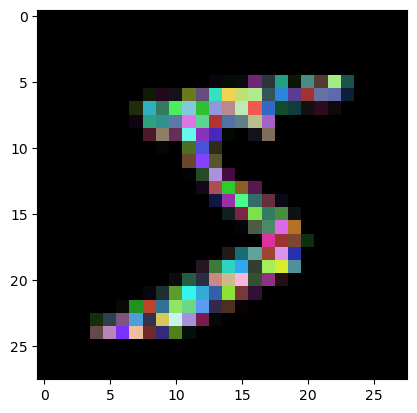

In [4]:
imshow((dataloader.dataset[0][0]/2 +.5).permute(1,2,0).numpy())

In [24]:
with open('./VAE_colorMNIST_parameters.yaml', 'rb') as f:
    try:
        config = yaml.safe_load(f)
    except yaml.YAMLError as exc:
        print(exc)

model = VAE_3D(config['model parameters'])
model = model.to(device)

In [25]:
lr = 0.0002
kl_weight = 0.00001
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
epochs = 20

def loss_function(x, x_pred, mu, logvar, kl_weight = 1, criterion = torch.nn.BCELoss()):
    loss = criterion(x_pred, x) - kl_weight * 0.5 * torch.mean(1-torch.exp(logvar) - mu**2 + logvar)
    
    return loss

In [26]:
losses = []

model.train()
for _ in range(epochs):
    pbar = tqdm.tqdm(dataloader)
    losses_epoch = []
    for batch, _ in pbar: 
        x = batch.float().to(device)
        x_hat, mu, logvar = model(x)

        optimizer.zero_grad()

        loss = loss_function(x/2+.5,x_hat/2 +.5, mu, logvar, kl_weight=kl_weight)
        loss.backward()
        optimizer.step()

        losses_epoch.append(loss.item())

        pbar.set_description(f'Loss: %.3f' % loss.item())
    
    mean_loss = mean(losses_epoch)
    losses.extend(losses_epoch)



Loss: 0.154:  67%|██████▋   | 624/938 [00:20<00:10, 30.90it/s]


KeyboardInterrupt: 

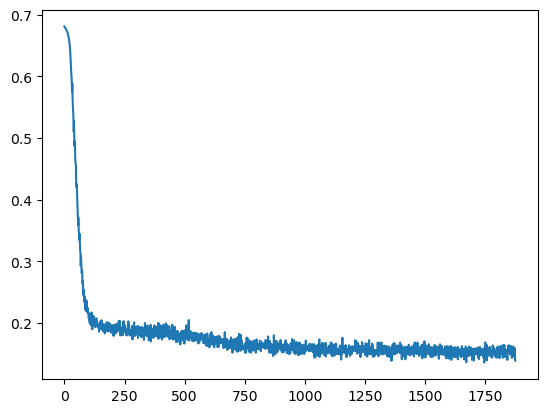

In [27]:
plot(losses)

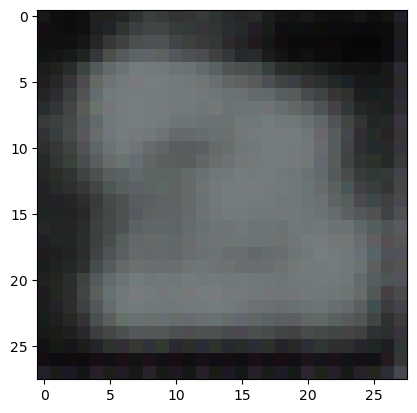

In [28]:
model.eval()
img_gen = model.sample(1)

imshow((img_gen[0]/2 +.5).cpu().permute(1,2,0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


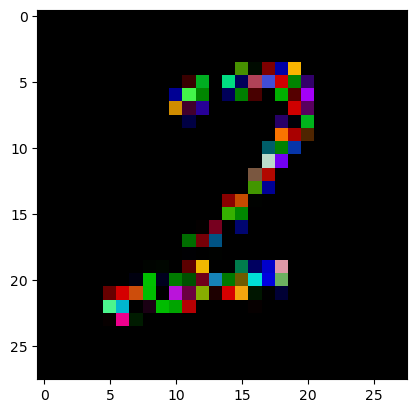

In [29]:
imshow(batch[0].numpy().transpose(1,2,0))

In [30]:
test_dataset = MNIST_colorized(training=False)

test_dataloader = DataLoader(test_dataset, batch_size=BS, shuffle=True)

In [33]:
batch = next(iter(test_dataloader))[0]
with torch.no_grad():
    x_pred, mu, logvar = model(batch.to(device).float())
    loss = loss_function(batch.to(device).float()/2+.5, x_pred/2+.5, mu, logvar, kl_weight=kl_weight)

In [34]:
loss.item()

0.15784698724746704

In [35]:
grid = torchvision.utils.make_grid(batch, nrow = 8)

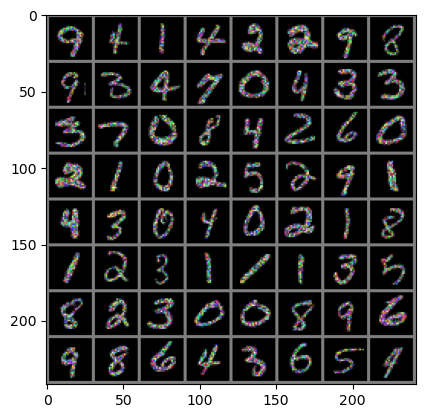

In [36]:
imshow((grid/2+.5).cpu().permute(1,2,0))

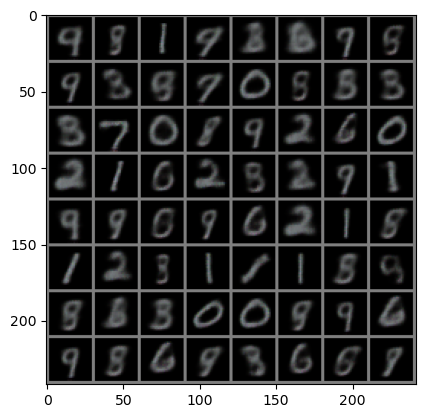

In [37]:
grid_pred = torchvision.utils.make_grid(x_pred, nrow = 8)
imshow((grid_pred/2+.5).cpu().permute(1,2,0))

In [95]:
#torch.save(model.state_dict(), './model_saves/VAE_colorMNIST.pth')
model.load_state_dict(torch.load('./model_saves/VAE_colorMNIST.pth'))

<All keys matched successfully>

# VQ-VAE

In [97]:
with open('./VQ_VAE_colorMNIST_parameters.yaml', 'rb') as f:
    try:
        config = yaml.safe_load(f)
    except yaml.YAMLError as exc:
        print(exc)

model = VQ_VAE(config['model parameters'])
model = model.to(device)

In [77]:

lr = 0.005
weight_decay = 1e-5
nb_epochs = 10
criterion = nn.MSELoss()
beta_commitment = 0.2

optim = torch.optim.AdamW(model.parameters(), lr = lr, weight_decay=weight_decay)

In [81]:
losses = []
losses_embed = []
losses_reconstruction = []

model.train()
for _ in range(nb_epochs):
    pbar = tqdm.tqdm(dataloader)
    for batch, _ in pbar:
        x = batch.float().to(device)
        x_hat, loss_embed, loss_commitment, _ = model(x)

        optim.zero_grad()
        loss_recon = criterion(x_hat, x)
        loss = loss_recon + loss_embed + beta_commitment * loss_commitment

        loss.backward()
        optim.step()

        losses.append(loss.item())
        losses_reconstruction.append(loss_recon.item())
        losses_embed.append(loss_embed.item())
        pbar.set_description(f'Loss: %.3f' % loss.item())

Loss: 0.093: 100%|██████████| 938/938 [00:37<00:00, 24.71it/s]


Text(0.5, 1.0, 'Losses plots')

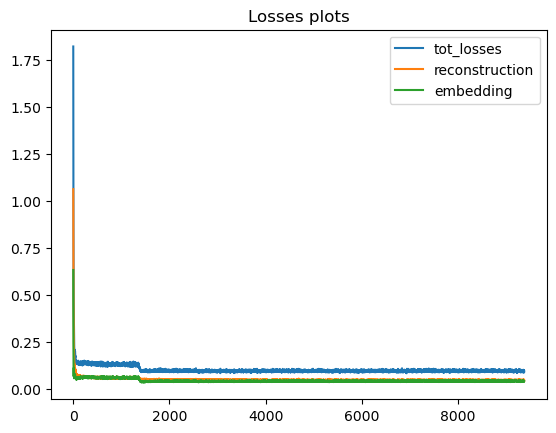

In [82]:
plot(losses, label = 'tot_losses')
plot(losses_reconstruction, label = 'reconstruction')
plot(losses_embed, label = 'embedding')
legend()
title('Losses plots')

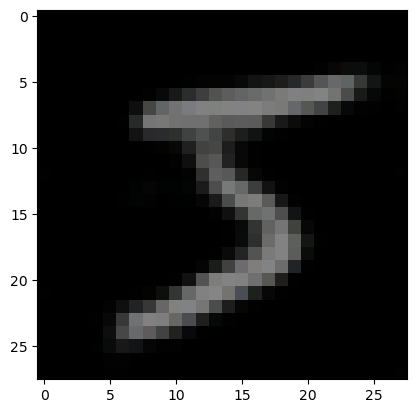

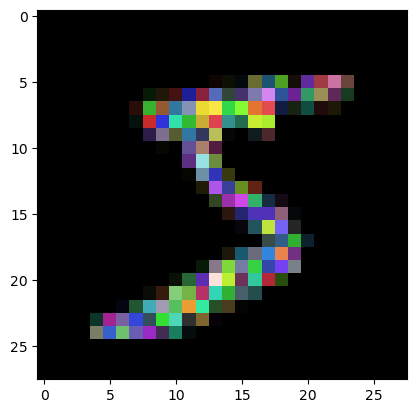

In [84]:
model.eval()
with torch.no_grad():
    imshow((model(dataloader.dataset[0][0].unsqueeze(0).float().to(device))[0]/2+.5).detach().cpu()[0].permute(1,2,0))
    show()
    imshow((dataloader.dataset[0][0]/2+.5).permute(1,2,0))
    show()

In [100]:
batch = next(iter(test_dataloader))[0]
with torch.no_grad():
    x_pred, loss_emb, loss_commit, _ = model(batch.to(device).float())
    loss_crit = criterion(x_pred, batch.float().to(device))
    loss = loss_emb + loss_commit + loss_crit

In [101]:
loss

tensor(0.1298, device='cuda:0')

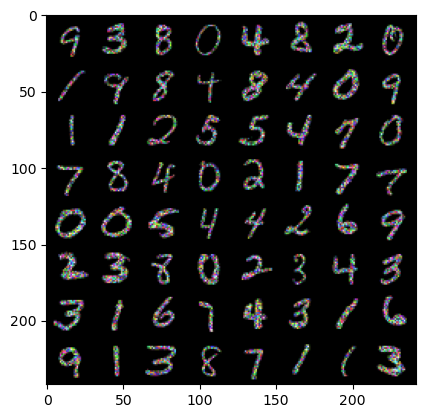

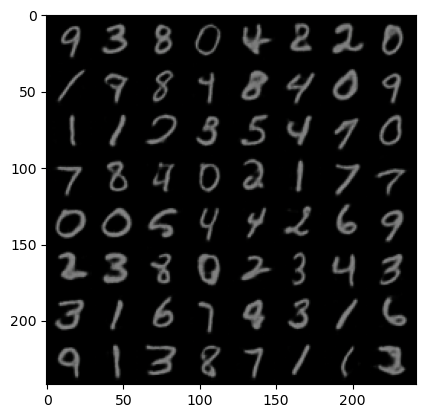

In [102]:
imshow(torchvision.utils.make_grid(batch.float()/2+.5, nrow = 8).permute(1,2,0).numpy())
show()
imshow(torchvision.utils.make_grid((x_pred/2+.5).cpu(), nrow = 8).permute(1,2,0).numpy())

In [98]:
#torch.save(model.state_dict(), './model_saves/VQVAE_colorMNIST.pth')
#model.load_state_dict(torch.load('./model_saves/VQVAE_colorMNIST.pth'))

<All keys matched successfully>

In [109]:
import pickle

to_save = None 

model.eval()
with torch.no_grad():
    for im, _ in dataloader:
        im = im.to(device).float()
        _,_,_, quant_idxs= model(im)

        if to_save is None:
            to_save = quant_idxs
        else:
            to_save = torch.cat([to_save, quant_idxs], dim = 0)
    pickle.dump(to_save, open('./additional_datasets/colorMNIST_quant_encodings.pkl', 'wb'))

In [121]:
fname_enc = 'colorMNIST_quant_encodings.pkl'

encodings_mnist = MnistQuantizedEncoding(config, model.out_encoder_size, fname_encodings = fname_enc)
encodings_dataloader = DataLoader(encodings_mnist, batch_size=BS, shuffle = True)

In [122]:
pixelcnn = PixelCNN_VQVAE(config['model parameters'])
pixelcnn = pixelcnn.to(device)

In [123]:
lr_pixel = 0.001
pixel_optim = torch.optim.AdamW(pixelcnn.parameters(), lr = lr_pixel)

loss_fn = nn.CrossEntropyLoss()

In [126]:
losses_pixelcnn = []

pixelcnn.train()
for _ in range(10):
    pixelcnn_pbar = tqdm.tqdm(encodings_dataloader)
    for x in pixelcnn_pbar:
        x = x.to(device).float()
        pixel_optim.zero_grad()

        out = pixelcnn(x)
        
        loss_pixelcnn = loss_fn(out, x.long().squeeze(1))

        loss_pixelcnn.backward()
        pixel_optim.step()

        losses_pixelcnn.append(loss_pixelcnn.item())
        pixelcnn_pbar.set_description('Loss PixelCNN: %.3f' % loss_pixelcnn.item())
        

Loss PixelCNN: 0.636: 100%|██████████| 938/938 [00:18<00:00, 49.59it/s]


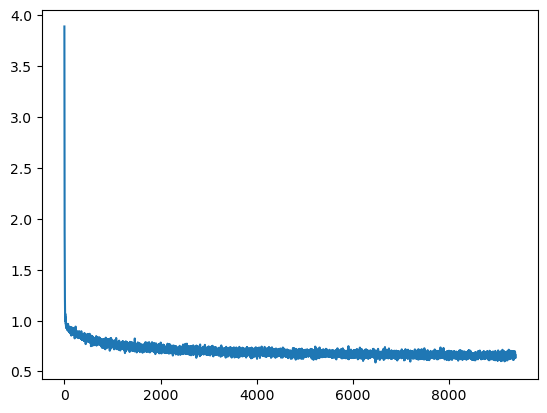

In [127]:
plot(losses_pixelcnn)

In [136]:
model.eval()
pixelcnn.eval()
with torch.no_grad():
    quantized_batch = pixelcnn.generate(nb_samples=100, img_size=model.out_encoder_size).long().squeeze(1)
    embedded_batch = model.quantizer.embedding(quantized_batch).permute(0,3,1,2)
    out = model.decoder(model.post_conv_quant(embedded_batch))
    out = (out+1)/2

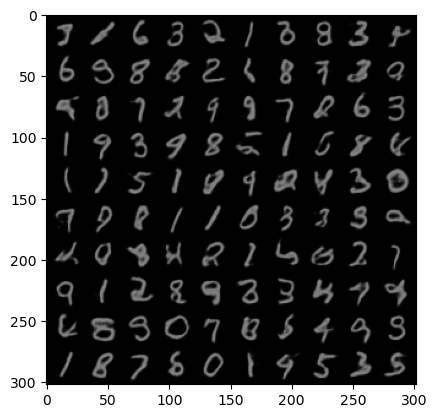

In [137]:
grid_gen = torchvision.utils.make_grid(out.cpu(), nrow = 10)
imshow(grid_gen.permute(1,2,0).numpy())

In [135]:
#torch.save(pixelcnn.state_dict(), './model_saves/pixelcnn_colorMNIST.pth')
#pixelcnn.load_state_dict(torch.load('./model_saves/pixelcnn_colorMNIST.pth'))

<All keys matched successfully>